**Section: 1 - Reading input data**

Following 4 paragraphs contains the Code to read input data files into colab from gdrive


In [66]:
# Include the required libraries
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [67]:
#Authenticate your google account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [68]:
#Download the train data
downloaded = drive.CreateFile({'id':'1PpBEZeSTgX3ZW9OgoXQ7VuqVwMDgA_7p'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.jsonl') 

In [69]:
#Download the test data
downloaded = drive.CreateFile({'id':'1E362ZrNp0_Ki8gOtITrze69L-sJ9CNsj'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test.jsonl') 

**Section: 2 - Preprocess data**

The input data (train) consists of 3 columns: label, reponse and context. In this step the response and context are combined into one single sentence in the order of last to first conversation sequence

In [70]:
#Import all the required libraries
import numpy as np
import pandas as pd
import time

#Import sklearn modules for generating classification report and for splitting the train data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Import torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Install transformers library for tokenizing the text data
!pip install transformers==3.0.0
import transformers
from transformers import AutoModel, RobertaTokenizer, RobertaTokenizerFast, BertTokenizer, BertTokenizerFast
from transformers import AdamW

# specify GPU
device = torch.device('cuda')

#Set seed manually to be able to replicate the results
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [71]:
#Readin json data to a python list

import json
tweets = []
for line in open('train.jsonl', 'r', encoding="utf8"):
    tweets.append(json.loads(line))

In [72]:
tweets[0:2]

[{'context': ['A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .',
   "@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯"],
  'label': 'SARCASM',
  'response': "@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her .."},
 {'context': ["@USER @USER Why is he a loser ? He's just a Press Secretary",
   '@USER @USER having to make up excuses of why your crowd was small .'],
  'label': 'SARCASM',
  'response': '@USER @USER trying to protest about . Talking about him and his labels and they label themselves WTF does that make em ?'}]

In [73]:
#Combining response and context into one single sentence

import pandas as pd
twt_df = pd.DataFrame(tweets)
twt_df["label"].value_counts()

new_df = twt_df.copy()

new_df["new_context"] =  ['.'.join(l[::-1]) for l in new_df['context']] 
#new_df["new_context"] =  [','.join(map(str, l)) for l in new_df['context']]
new_df["text"] = new_df["response"] + new_df["new_context"]

new_df["label"]=new_df["label"].map({"SARCASM": 1, "NOT_SARCASM":0})

In [75]:
new_df["text"].to_list()[0:5]

["@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯.A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .",
 "@USER @USER trying to protest about . Talking about him and his labels and they label themselves WTF does that make em ?@USER @USER having to make up excuses of why your crowd was small ..@USER @USER Why is he a loser ? He's just a Press Secretary",
 '@USER @USER @USER He makes an insane about of money from the MOVIES , Einstein ! #LearnHowTheSystemWorks@USER I ’ ll remember to not support you at the box office ..Donald J . Trump is guilty as charged . The evidence is clear . If your Senator votes to acquit , remember him / her at the ballot box .',
 "@USER @USER 

**Section: 3 - Prepare data for modeling**

*   Split the data into training and validation
*   Trim the conversations
*   Tokenize and encode sequences
*   Create train and validation tensor datasets


In [76]:
#Split the data into training (80%) and validation (20%)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(new_df["text"], new_df["label"], test_size=0.2, stratify=new_df["label"], random_state=seed)

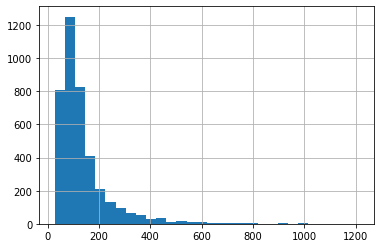

In [77]:
#Distribution of conversation lengths

seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

In [78]:
#Specifying max sentence length 
max_len=200

In [79]:
#Load the required tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base') 

#Tokenize and encode sequences in the training and validation sets
train_tks = tokenizer.batch_encode_plus(X_train.tolist(), max_length = max_len, pad_to_max_length=True, truncation=True, return_tensors='pt')
val_tks = tokenizer.batch_encode_plus(X_val.tolist(), max_length = max_len, pad_to_max_length=True, truncation=True, return_tensors='pt')

In [80]:
## Create train and validation tensor datasets
train_text = train_tks['input_ids']
train_mask = train_tks['attention_mask']
train_y = torch.tensor(y_train.tolist())

val_text = val_tks['input_ids']
val_mask = val_tks['attention_mask']
val_y = torch.tensor(y_val.tolist())

train_data = TensorDataset(train_text, train_mask, train_y) # wrap tensors
val_data = TensorDataset(val_text, val_mask, val_y)

**Section :4 - Define model build functions**

Contains train and validate functions to build the model

In [81]:
class TxtClsf(nn.Module):

    def __init__(self, pre_train_lm):
      
      super(TxtClsf, self).__init__()

      self.embeds = pre_train_lm
    
      # Linear layer
      self.linear_layers = nn.Sequential(
                nn.Linear(in_features=768, out_features=512),          
                nn.ReLU(),
                nn.Dropout(p=0.1),
                nn.Linear(in_features=512, out_features=2)
        )
      
      self.activate = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, text, mask):

      #pass the inputs to the model  
      _, cls_hs = self.embeds(text, attention_mask=mask)
      
      x = self.linear_layers(cls_hs)
      x = self.activate(x)

      return x

In [82]:
# function to train the model
def train(train_data,batch_size):
  
  model.train()
  total_loss, total_matches = 0, 0

  train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size) # dataLoader for train set
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):    
  
    batch = [r.to(device) for r in batch] # push the batch to gpu  
    text, mask, labels = batch    
    model.zero_grad() # clear previously calculated gradients       

    preds = model(text, mask) # get model predictions for the current batch
    loss = criterion(preds, labels) # compute the loss between actual and predicted values    
    total_loss = total_loss + loss.item() # add on to the total loss    
    matches = (preds.argmax(1) == labels).sum().item() # Compute matches with each batch 
    total_matches = total_matches + matches # Aggregate the matches for computing final accuracy
    
    loss.backward() # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    optimizer.step() # update parameters

  avg_loss = total_loss / len(train_dataloader) # compute the training loss of the epoch
  accuracy = total_matches / len(train_data) # Compute overall accuracy within each epoch

  #returns the loss and predictions
  return avg_loss, accuracy

# function for evaluating the model
def validate(val_data,batch_size):

  model.eval()
  total_loss, total_matches = 0, 0

  val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    text, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(text, mask)

      # compute the validation loss and accuracy between actual and predicted values
      loss = criterion(preds,labels)
      total_loss = total_loss + loss.item()
      matches = (preds.argmax(1) == labels).sum().item()
      total_matches = total_matches + matches

  # compute the average validation loss and accuracy of the epoch
  avg_loss = total_loss / len(val_dataloader)
  accuracy = total_matches / len(val_data)

  return avg_loss, accuracy

**Section: 5 - Run the model**

*   Define model paramters
*   Run the model and store the best model


In [83]:
pre_train_mdl = AutoModel.from_pretrained('roberta-base') # import pretrained roberta-base model
model = TxtClsf(pre_train_mdl) # pass the pre-trained RoBERTA to our define architecture
model = model.to(device) # push the model to GPU

optimizer = AdamW(model.parameters(),lr = 1e-5) # define the optimizer
criterion  = nn.NLLLoss() # define the loss function
#criterion  = nn.CrossEntropyLoss()
epochs = 10 # number of training epochs
batch_size=32

In [84]:
best_valid_loss = float('inf') # Set initial loss to infinite
best_valid_acc = 0 #Set initial accuracy to zero

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

train_accs=[]
valid_accs=[]

#Train and validate for each epoch
for epoch in range(epochs):
    
    start_time = time.time()
    train_loss, train_acc = train(train_data,batch_size) #train model
    valid_loss, valid_acc = validate(val_data,batch_size) #evaluate model

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    #Print loss and acccuracy values to the output
    print('Epoch: %d' %(epoch + 1), " completed in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    
    #Optional - save the model having lowest validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'loss_weights.pt')

    #save the best (having highest validation accuracy) model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'acc_weights.pt')
    
    #Append training and validation loss and accuracy values
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

Epoch: 1  completed in 2 minutes, 46 seconds
	Loss: 0.5909(train)	|	Acc: 67.1%(train)
	Loss: 0.5184(valid)	|	Acc: 76.7%(valid)
Epoch: 2  completed in 2 minutes, 45 seconds
	Loss: 0.4461(train)	|	Acc: 79.6%(train)
	Loss: 0.4358(valid)	|	Acc: 80.4%(valid)
Epoch: 3  completed in 2 minutes, 46 seconds
	Loss: 0.3805(train)	|	Acc: 84.2%(train)
	Loss: 0.4129(valid)	|	Acc: 82.2%(valid)
Epoch: 4  completed in 2 minutes, 46 seconds
	Loss: 0.3192(train)	|	Acc: 87.2%(train)
	Loss: 0.4211(valid)	|	Acc: 83.7%(valid)
Epoch: 5  completed in 2 minutes, 46 seconds
	Loss: 0.2523(train)	|	Acc: 90.7%(train)
	Loss: 0.4497(valid)	|	Acc: 82.7%(valid)
Epoch: 6  completed in 2 minutes, 46 seconds
	Loss: 0.2032(train)	|	Acc: 92.7%(train)
	Loss: 0.4497(valid)	|	Acc: 83.8%(valid)
Epoch: 7  completed in 2 minutes, 46 seconds
	Loss: 0.1887(train)	|	Acc: 93.3%(train)
	Loss: 0.4669(valid)	|	Acc: 83.4%(valid)
Epoch: 8  completed in 2 minutes, 45 seconds
	Loss: 0.1396(train)	|	Acc: 95.8%(train)
	Loss: 0.6186(valid)	|	Ac

**Section:6 - Test predictions**

*   Load the best model -  model with highest validation accuracy in prior step
*   Preprocess test data same as the training data
*   Split the test dataset into 2 parts to overcome limited space issue in colab
*   Get the predictions for the 2 test sets and combine into one final dataframe


In [86]:
#load weights of best model (Choose between best accuracy or least loss)
path = 'acc_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [90]:
#Preprocess test dataset same as training

import json
tsts = []
for line in open('test.jsonl', 'r', encoding="utf8"):
    tsts.append(json.loads(line))

import pandas as pd
tst_df = pd.DataFrame(tsts)

tst_df["new_context"] =  ['.'.join(l[::-1]) for l in tst_df['context']]
#tst_df["new_context"] =  [','.join(map(str, l)) for l in tst_df['context']]
tst_df["text"] = tst_df["response"] + tst_df["new_context"]

In [91]:
# Tokenize and encode sequences in the test set - 1
# 1000 records are processed at a time due to colab space limitations
test_text = tst_df["text"][0:1000]
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length = max_len, pad_to_max_length=True, truncation=True)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [92]:
# Get predictions for test dataset-1
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [93]:
preds1 = np.argmax(preds, axis = 1)

In [94]:
# Tokenize and encode sequences for the test set - 2
test_text = tst_df["text"][1000:]
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length = max_len, pad_to_max_length=True, truncation=True)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [95]:
# Get predictions for test set-2
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [96]:
preds2 = np.argmax(preds, axis = 1)

In [97]:
#Combine the predictions from the 2 test sets
predictions = list()
predictions.extend(list(preds1))
predictions.extend(list(preds2))

In [98]:
#Distribution of final labels in the test set
pd.Series(predictions).value_counts()`  `

1    1100
0     700
dtype: int64

In [99]:
#Assign appropriate text labels

predictions=pd.Series(predictions).map({1:"SARCASM", 0:"NOT_SARCASM"})

In [100]:
#Create final predicted dataframe

test_preds = pd.DataFrame({'id':tst_df['id'],'label':predictions})
test_preds.to_csv(index=False)

'id,label\ntwitter_1,NOT_SARCASM\ntwitter_2,SARCASM\ntwitter_3,SARCASM\ntwitter_4,NOT_SARCASM\ntwitter_5,SARCASM\ntwitter_6,SARCASM\ntwitter_7,NOT_SARCASM\ntwitter_8,SARCASM\ntwitter_9,SARCASM\ntwitter_10,SARCASM\ntwitter_11,SARCASM\ntwitter_12,SARCASM\ntwitter_13,NOT_SARCASM\ntwitter_14,NOT_SARCASM\ntwitter_15,SARCASM\ntwitter_16,SARCASM\ntwitter_17,SARCASM\ntwitter_18,SARCASM\ntwitter_19,SARCASM\ntwitter_20,NOT_SARCASM\ntwitter_21,SARCASM\ntwitter_22,SARCASM\ntwitter_23,NOT_SARCASM\ntwitter_24,NOT_SARCASM\ntwitter_25,SARCASM\ntwitter_26,SARCASM\ntwitter_27,SARCASM\ntwitter_28,NOT_SARCASM\ntwitter_29,SARCASM\ntwitter_30,SARCASM\ntwitter_31,SARCASM\ntwitter_32,NOT_SARCASM\ntwitter_33,SARCASM\ntwitter_34,SARCASM\ntwitter_35,NOT_SARCASM\ntwitter_36,SARCASM\ntwitter_37,SARCASM\ntwitter_38,SARCASM\ntwitter_39,SARCASM\ntwitter_40,SARCASM\ntwitter_41,SARCASM\ntwitter_42,NOT_SARCASM\ntwitter_43,SARCASM\ntwitter_44,NOT_SARCASM\ntwitter_45,NOT_SARCASM\ntwitter_46,NOT_SARCASM\ntwitter_47,SARCASM